# Sentiment Analysis: R Data Science Project

The aim of this project is to build a sentiment analysis model which will allow us to categorize words based on their sentiments, that is whether they are positive, negative and also the magnitude of it.

## Overview of Sentiment Analysis

*Sentiment Analysis* is a process of extracting opinions that have different polarities (positive, negative or neutral). It is also known as opinion mining and polarity detection. With the help of sentiment analysis, we can find out the nature of opinion that is reflected in documents, websites, social media feed, etc. Sentiment Analysis is a type of classification where the data is classified into different classes. These classes can be binary in nature (positive or negative) or, they can have multiple classes (happy, sad, angry, etc.).

## Developing the Sentiment Analysis Model in R

We will carry out sentiment analysis with R in this project. The dataset that we will use will be provided by the R package `janeaustenR`.

In order to build our project on sentiment analysis, we will make use of the `tidytext` package that comprises of sentiment lexicons that are present in the dataset `sentiments`.

In [1]:
# Load required libraries
library(tidytext)
library(janeaustenr)
library(stringr)
library(tidyverse)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v purrr     1.0.2
v forcats   1.0.0     v readr     2.1.5
v ggplot2   3.4.2     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.1
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


We will make use of three general purpose lexicons like –

- AFINN
- bing
- nrc

These three lexicons make use of unigrams. Unigrams are a type of n-gram model that consists of a sequence of 1 item, that is, a word collected from a given textual data. The `AFINN` lexicon model scores the words in a range from -5 to 5. The `bing` lexicon model on the other hand, classifies the sentiment into a binary category of negative or positive. The `nrc` lexicon categorizes words in a binary fashion (“yes”/“no”) into categories of positive, negative, anger, anticipation, disgust, fear, joy, sadness, surprise, and trust. In this project, we will make use of the bing lexicons to extract the sentiments out of our data. We can retrieve these lexicons using the `get_sentiments()` function.

In [2]:
head(get_sentiments("bing"))

word,sentiment
<chr>,<chr>
2-faces,negative
abnormal,negative
abolish,negative
abominable,negative
abominably,negative
abominate,negative


## Performing Sentiment Analysis with Inner Join

The `janeaustenr` package will provide us with the textual data in the form of books authored by the novelist Jane Austen. `Tidytext` will allow us to perform efficient text analysis on our data. We will convert the text of our books into a tidy format using `unnest_tokens()` function.

In [3]:
tidy_books <- austen_books() %>%
group_by(book) %>%
mutate(linenumber = row_number(),
      chapter = cumsum(str_detect(text, regex("^chapter [\\divxlc]", ignore_case = TRUE)))
       ) %>%
ungroup() %>%
unnest_tokens(word, text)

head(tidy_books)

book,linenumber,chapter,word
<fct>,<int>,<int>,<chr>
Sense & Sensibility,1,0,sense
Sense & Sensibility,1,0,and
Sense & Sensibility,1,0,sensibility
Sense & Sensibility,3,0,by
Sense & Sensibility,3,0,jane
Sense & Sensibility,3,0,austen


We have performed the tidy operation on our text such that each row contains a single word. We will now make use of the “bing” lexicon to implement `filter()` over the words that correspond to a positive sentiment. We will use the book **Emma** and derive its words to implement our sentiment analysis model.

In [4]:
# Most common positive words in the book Emma
positive_senti <- get_sentiments("bing") %>%
filter(sentiment == "positive")

tidy_books %>% 
filter(book == "Emma") %>%
semi_join(positive_senti) %>%
count(word, sort = TRUE)

Joining with `by = join_by(word)`


word,n
<chr>,<int>
well,401
good,359
great,264
like,200
better,173
enough,129
happy,125
love,117
pleasure,115


From our above results, we observe many positive words like “good”, “happy”, “love” etc. 

We can also examine how sentiment changes throughout each novel. We can do this with just a handful of lines that are mostly `dplyr` functions. First, we find a sentiment score for each word using the **Bing** lexicon and `inner_join()`.

Next, we count how many positive and negative words there are in defined sections of each book. We define an `index` here to keep track of which 80-line section of text we are counting the sentiments in; this index (using integer division %/%) counts sections of 80 lines of text.

Small sections of text may not have enough words in them to get a good estimate of sentiment while really large sections can wash out narrative structure. For these books, using 80 lines works well, but this can vary depending on individual texts, how long the lines were to start with, etc. We then use `pivot_wider()` so that we have negative and positive sentiment in separate columns, and lastly calculate a *net sentiment* (positive - negative).

In [5]:
janeausten_sentiment <- tidy_books %>%
inner_join(get_sentiments("bing")) %>% 
count(book, index = linenumber %/% 80, sentiment) %>%
pivot_wider(names_from = sentiment, values_from = n, values_fill = 0) %>%
mutate(sentiment = positive - negative)

head(janeausten_sentiment)

Joining with `by = join_by(word)`
Warning message in inner_join(., get_sentiments("bing")):
"Detected an unexpected many-to-many relationship between `x` and `y`.
i Row 435434 of `x` matches multiple rows in `y`.
i Row 5051 of `y` matches multiple rows in `x`.
i If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning."


book,index,negative,positive,sentiment
<fct>,<dbl>,<int>,<int>,<int>
Sense & Sensibility,0,16,32,16
Sense & Sensibility,1,19,53,34
Sense & Sensibility,2,12,31,19
Sense & Sensibility,3,15,31,16
Sense & Sensibility,4,16,34,18
Sense & Sensibility,5,16,51,35


Now we can plot these sentiment scores across the plot trajectory of each novel. Notice that we are plotting against the `index` on the x-axis that keeps track of narrative time in sections of text.

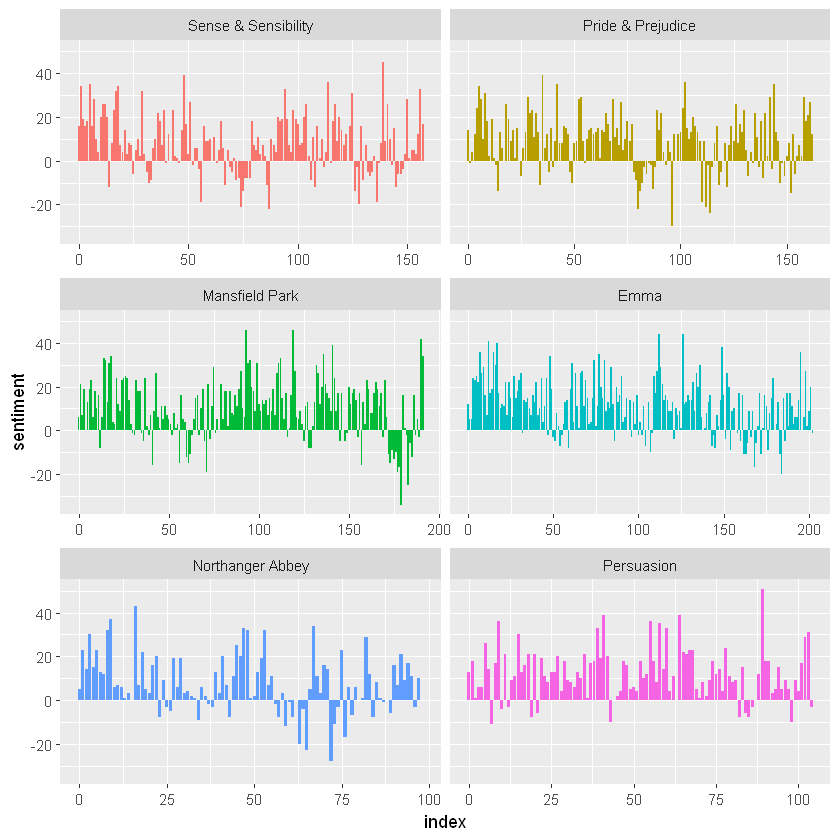

In [6]:
library(ggplot2)

ggplot(janeausten_sentiment, aes(x = index, y = sentiment, fill = book)) +
       geom_col(show.legend = FALSE) +
       facet_wrap(~book, ncol = 2, scales = "free_x")

We can see above how the plot of each novel changes towards a more positive or negative sentiment over the trajectory of the story.

We will now proceed with counting the most common positive and negative words that are present in the novel.

In [7]:
bing_word_counts <- tidy_books %>%
inner_join(get_sentiments("bing")) %>%
count(word, sentiment, sort = TRUE)

head(bing_word_counts)

Joining with `by = join_by(word)`
Warning message in inner_join(., get_sentiments("bing")):
"Detected an unexpected many-to-many relationship between `x` and `y`.
i Row 435434 of `x` matches multiple rows in `y`.
i Row 5051 of `y` matches multiple rows in `x`.
i If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning."


word,sentiment,n
<chr>,<chr>,<int>
miss,negative,1855
well,positive,1523
good,positive,1380
great,positive,981
like,positive,725
better,positive,639


In the next step, we will perform visualization of our sentiment score. We will plot the scores along the axis that is labeled with both positive as well as negative words. We will use `ggplot()` function to visualize our data based on their scores.

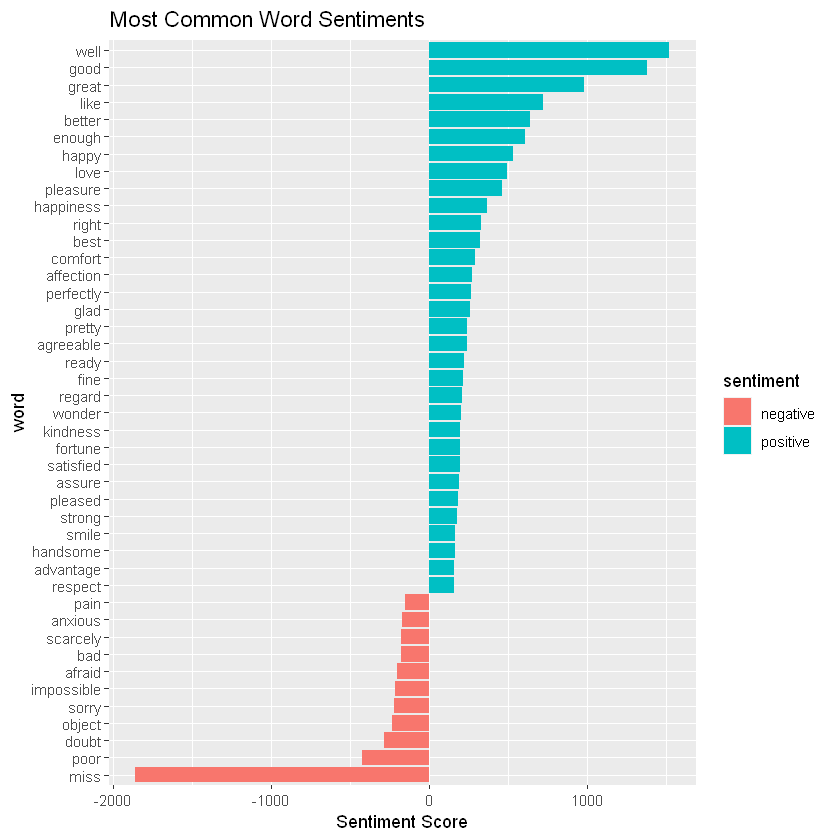

In [8]:
bing_word_counts %>%
filter(n > 150) %>%
mutate(n = ifelse(sentiment == "negative", -n, n)) %>%
mutate(word = reorder(word, n)) %>%
ggplot(aes(x = n, y = word, fill = sentiment)) +
geom_col() +
labs( x = "Sentiment Score",
    title = "Most Common Word Sentiments")

There is an anomaly in the sentiment analysis; the word “miss” is coded as negative but it is used as a title for young, unmarried women in Jane Austen’s works. If appropriate, we could easily add “miss” to a custom stop-words list using `dplyr::bind_rows()`. 

In [9]:
custom_stop_words <- bind_rows(tibble(word = c("miss"),
                                      lexicon = c("custom")),
                              stop_words)

head(custom_stop_words)

word,lexicon
<chr>,<chr>
miss,custom
a,SMART
a's,SMART
able,SMART
about,SMART
above,SMART


In the final visualization, we will create a wordcloud that will delineate the most recurring positive and negative words. In particular, we will use the `comparision.cloud()` function to plot both negative and positive words in a single wordcloud as follows:

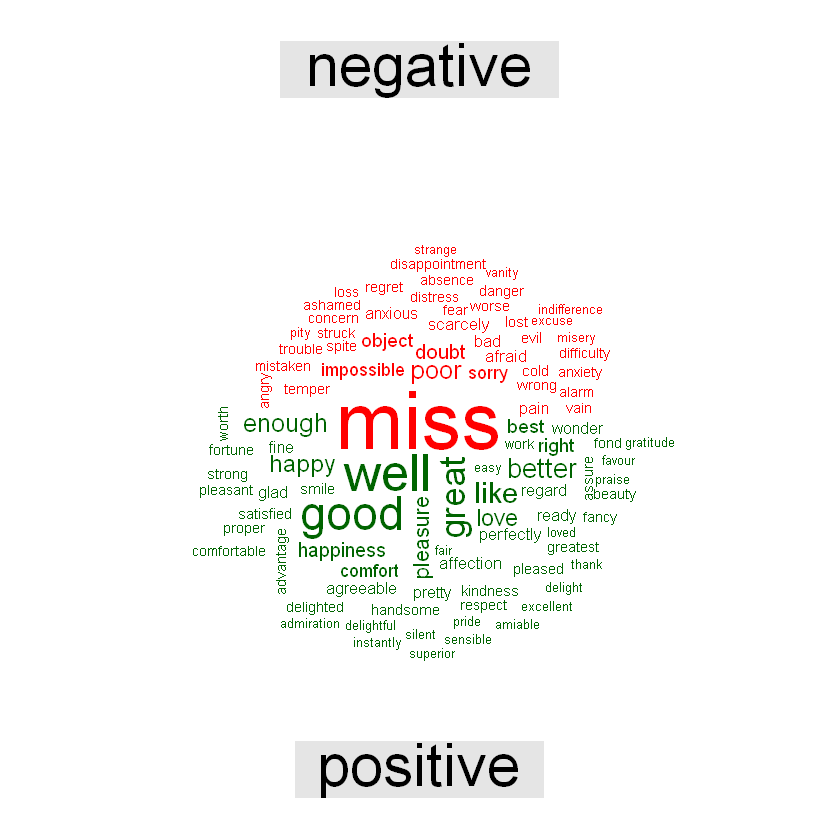

In [27]:
library(reshape2)
library(wordcloud)
bing_word_counts %>%
pivot_wider(names_from = sentiment,
            values_from = n,
            values_fill = 0
           ) %>% # can also use acast(word ~ sentiment, value.var = "n", fill = 0)
column_to_rownames(var = "word") %>%
comparison.cloud(colors = c("red", "dark green"),
          max.words = 100)

This word cloud will enable us to efficiently visualize the negative as well as positive groups of data. Therefore, we are now able to see the different groups of data based on their corresponding sentiments.

## Conclusion

We were able to delineate sentiment analysis through various visualizations after we performed data wrangling on our data. We used a lexical analyzer – ‘bing’ in this instance of our project. Furthermore, we also represented the sentiment score through a plot and also made a visual report of word cloud.